# Working with your own input data

In notebook you will work with input tiles that you generate yourself. The idea is to create a few 100s of input tiles of 256x256 pixels and then feed them through the pre-trained model. We will cheat slightly here since the model was actually trained on true-color RGB composite satellite images of tiles, and not on grey-scale images, but as you will see this model can still extract patterns in a meaningful way(!)

There is an example below that generates 100 tiles that have different wavelength patterns in them (I've called the dataset "random_waves" to indicate this). These are then loaded as a `ImageSingletDataset` that can be fed through the model in the same way as triplets normally are. And finally we can work with the embeddings as before.

Things to work on:

- Does the neural network group tiles together with the same wave-length pattern? What if you change the number of wavelengths? Or create a different kind of pattern (diagonal bands for example)? What if you put different wave-lengths in the different colors?
- Try some of your own data (you can use the `to_pil_image` function below to make a grey-scale image from any 2D numpy array). How does it work on your data?

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import convml_tt
from convml_tt.data.examples import (
    load_pretrained_model,
    PretrainedModel,
)
import convml_tt.interpretation.plots
from convml_tt.utils import get_embeddings
from convml_tt.data.dataset import ImageSingletDataset, TileType
from convml_tt.data.transforms import get_transforms

convml_tt.__version__

'v0.12.0+1.g0008dcf.dirty'

<IPython.core.display.Javascript object>

## Generating synthetic anchor images for *study*

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import xarray as xr
from pathlib import Path

<IPython.core.display.Javascript object>

In [4]:
Nx = Ny = 256

x_, y_ = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
x, y = np.meshgrid(x_, y_, indexing="ij")

<IPython.core.display.Javascript object>

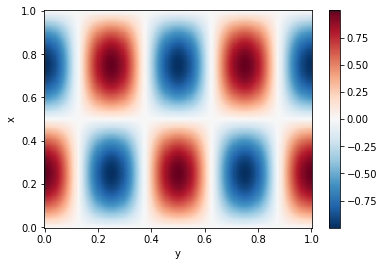

<IPython.core.display.Javascript object>

In [5]:
# example tile
arr = np.sin(x * 3.14 * 2.0) * np.cos(y * 3.14 * 4)

da = xr.DataArray(arr, dims=("x", "y"), coords=dict(x=x_, y=y_))

da.plot()

Next we want to take this 2D array and turn it into a RGB (red-green-blue) image. We will cheat here and simply copy the values three times across to make these three channels.

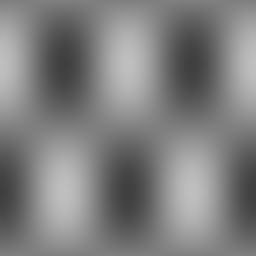

<IPython.core.display.Javascript object>

In [6]:
TILE_FN_FORMAT = "{tile_id:05d}_anchor.png"


def to_pil_image(arr, vmin=-2.0, vmax=2.0):
    # scale values to between zero and one
    v = (arr - vmin) / (vmax - vmin)
    # copy the
    v_channels = np.stack([v, v, v], axis=-1)
    # scale to 0-254 and make uint for image
    im = Image.fromarray(np.uint8(v_channels * 255))
    return im


to_pil_image(da.values)

In [7]:
# make tiles with 5 different wavelengths, every time shifted
# by a random amount in x and y

N_tiles = 100
tile_id = 0
dataset_name = "random_waves"
output_path = Path(dataset_name)
output_path.mkdir(exist_ok=True)

while tile_id < N_tiles:
    frq_x = 3.14 * np.random.choice(np.arange(5))
    frq_y = 2 * frq_x
    x_offset, y_offset = np.random.normal(size=2)
    arr = np.sin((x + x_offset) * frq_x) * np.cos((y + y_offset) * frq_y)

    # add some random noise
    arr += 0.3 * np.random.randn(*arr.shape)

    da = xr.DataArray(arr, dims=("x", "y"), coords=dict(x=x_, y=y_))

    img = to_pil_image(da)

    fn = TILE_FN_FORMAT.format(tile_id=tile_id)
    img.save(output_path / fn)
    tile_id += 1

<IPython.core.display.Javascript object>

# Feeding through neural network

In [8]:
model = load_pretrained_model(pretrained_model=PretrainedModel.FIXED_NORM_STAGE2)

Using downloaded and verified file: data/fixednorm-stage-2.tgz
Extracting data/fixednorm-stage-2.tgz to data/
Weights loaded from `data/fixednorm-stage-2.torch.pkl`


<IPython.core.display.Javascript object>

In [9]:
tds = ImageSingletDataset(
    data_dir="random_waves/",
    tile_type=TileType.ANCHOR,
    transform=get_transforms(step="predict", normalize_for_arch=model.base_arch),
    stage=None,
)
len(tds)

100

<IPython.core.display.Javascript object>

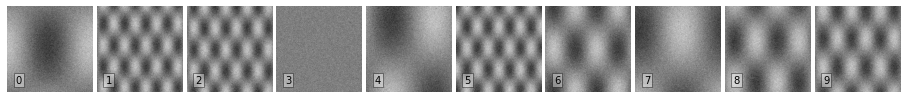

<IPython.core.display.Javascript object>

In [10]:
# before we produce embeddings with the trained model, let's have a look
# at the tiles that will be fed in (that we created above)

convml_tt.interpretation.plots.grid_overview(tds, points=10)

In [11]:
# we now feed this tile-dataset through the trained model to produce embedding vectors for each
da_embs = get_embeddings(tile_dataset=tds, model=model)
da_embs

/Volumes/agile/tooling/miniconda3/envs/convml-tt-sense/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

<xarray.DataArray (tile_id: 100, emb_dim: 100)>
array([[-0.01597606,  0.04193109, -0.01011256, ..., -0.04683957,
        -0.00994303,  0.01322105],
       [ 0.08225513, -0.03984076, -0.01790754, ...,  0.02013741,
        -0.03421361, -0.01602107],
       [ 0.0823888 , -0.04428861, -0.0157019 , ...,  0.00838837,
        -0.02954531, -0.01400342],
       ...,
       [ 0.08916622, -0.04713536, -0.0172761 , ...,  0.02309959,
        -0.02699469, -0.00790988],
       [ 0.0833407 , -0.04510039, -0.01615892, ...,  0.0176133 ,
        -0.03075013, -0.01896307],
       [ 0.01134043,  0.01293184,  0.00449065, ..., -0.02472747,
         0.02268609,  0.03131557]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: emb_dim
Attributes:
    tile_type:  ANCHOR
    stage:      None
    data_dir:   /Users/leifdenby/git-repos/SENSE_convml_tt/notebooks/random_w...

<IPython.core.display.Javascript object>

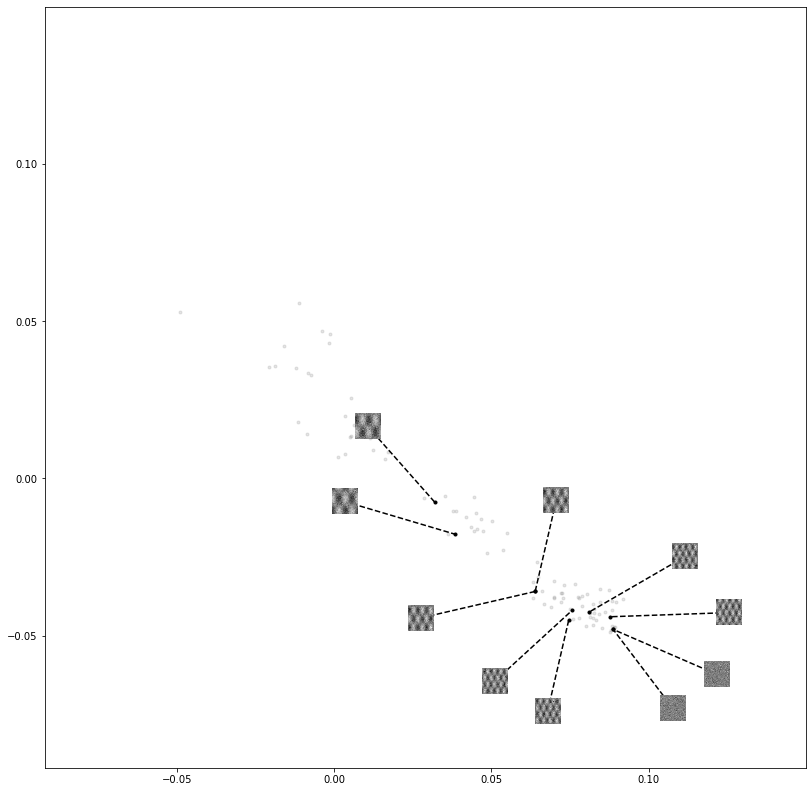

<IPython.core.display.Javascript object>

In [12]:
x = da_embs.sel(emb_dim=0)
y = da_embs.sel(emb_dim=1)
_ = convml_tt.interpretation.plots.annotated_scatter_plot(x, y, points=10)

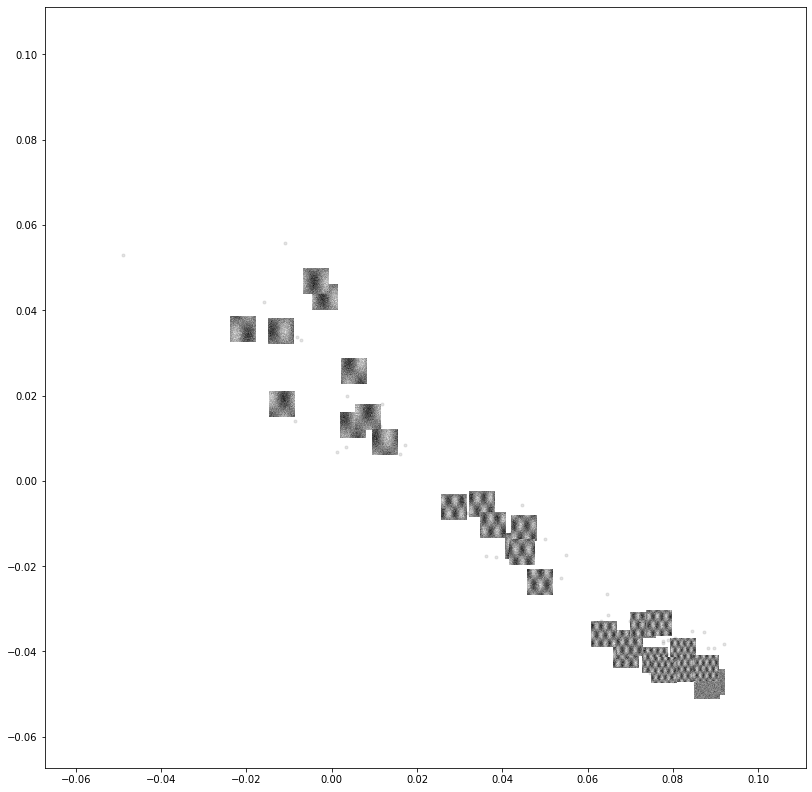

<IPython.core.display.Javascript object>

In [13]:
x = da_embs.sel(emb_dim=0)
y = da_embs.sel(emb_dim=1)
_ = convml_tt.interpretation.plots.annotated_scatter_plot(
    x, y, points=30, autopos_method=None
)